In [48]:
# import ee
# import geemap
# import wxee
import geopandas as gpd
import richdem as rd
import numpy as np
import rioxarray
import xarray as xr
import elevation
# from pathlib import Path

In [35]:
gdf = gpd.read_file("roi.shp")
[*gdf.bounds.values]

[array([37.134983,  9.478976, 37.207096,  9.613049])]

In [30]:
ls

dem.tif*             full_catchment.tif*          point.prj*  roi.shx*
DEM.tif*             full_catchment.tif.aux.xml*  point.shp*  srtm_dem.tif*
DEM.tif.aux.xml*     GeemapDownload.ipynb*        point.shx*  srtm.tif*
era5ee-Copy1.ipynb*  hadocha_dem.tif*             roi.cpg*
era5ee.ipynb*        point.cpg*                   roi.dbf*
full_acc.tiff*       point.dbf*                   roi.shp*


In [74]:
elevation.clip(*gdf.bounds.values,margin="1.0",output="roi.tif")
ds = rioxarray.open_rasterio("/home/feefladder/.cache/elevation/SRTM1/roi.tif").to_dataset(name="elevation")

make: Entering directory '/home/feefladder/.cache/elevation/SRTM1'
curl -s -o spool/N08/N08E036.hgt.gz.temp https://s3.amazonaws.com/elevation-tiles-prod/skadi/N08/N08E036.hgt.gz && mv spool/N08/N08E036.hgt.gz.temp spool/N08/N08E036.hgt.gz
gunzip spool/N08/N08E036.hgt.gz 2>/dev/null || touch spool/N08/N08E036.hgt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 spool/N08/N08E036.hgt cache/N08/N08E036.tif 2>/dev/null || touch cache/N08/N08E036.tif
curl -s -o spool/N09/N09E036.hgt.gz.temp https://s3.amazonaws.com/elevation-tiles-prod/skadi/N09/N09E036.hgt.gz && mv spool/N09/N09E036.hgt.gz.temp spool/N09/N09E036.hgt.gz
gunzip spool/N09/N09E036.hgt.gz 2>/dev/null || touch spool/N09/N09E036.hgt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 spool/N09/N09E036.hgt cache/N09/N09E036.tif 2>/dev/null || touch cache/N09/N09E036.tif
curl -s -o spool/N10/N10E036.hgt.gz.temp https://s3.amazonaws.com/elevation-tiles-prod/skadi/N10/N1

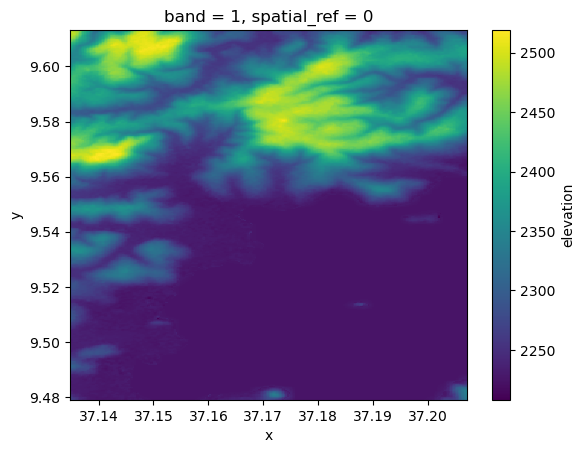

In [75]:
ds.elevation.plot()

In [3]:
# ds = rioxarray.open_rasterio("srtm.tif").to_dataset(name="elevation")

In [4]:
# ds

<xarray.Dataset>
Dimensions:      (band: 1, x: 3601, y: 3601)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 37.0 37.0 37.0 37.0 37.0 ... 38.0 38.0 38.0 38.0
  * y            (y) float64 10.0 10.0 9.999 9.999 9.999 ... 9.001 9.001 9.0 9.0
    spatial_ref  int64 0
Data variables:
    elevation    (band, y, x) int16 ...

In [55]:
# ds = ds.rio.write_crs("epsg:4326")
ds = ds.squeeze()
# ds["elevation"] = ds.elevation.astype("float32")

In [56]:
rdsheds = rd.rdarray(ds.elevation.fillna(ds.elevation._FillValue),no_data=ds.elevation._FillValue)

# rd.rdShow()
ds["filled"] = ds.elevation
ds.filled.data = rd.FillDepressions(rdsheds, epsilon=True,in_place=False)
# ds.filled.rio.to_raster("full_acc.tiff")

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Priority-Flood+Epsilon
C Barnes, R., Lehman, C., Mulla, D., 2014. Priority-flood: An optimal depression-filling and watershed-labeling algorithm for digital elevation models. Computers & Geosciences 62, 117–127. doi:10.1016/j.cageo.2013.04.024

c topology = D8
p Setting up boolean flood array matrix...
p Adding cells to the priority queue...
p Performing Priority-Flood+Epsilon...
t succeeded in 0.023539 s==================== ] (99% - 0.0s - 1 threads)
m Cells processed = 125580
m Cells in pits = 1291


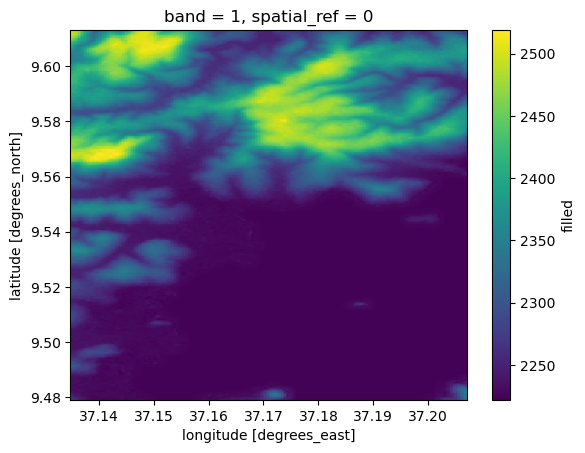

In [66]:
ds.filled.plot()

/home/feefladder/miniconda3/envs/thesis/lib/python3.10/site-packages/rioxarray/raster_writer.py:115: UserWarning: The nodata value (-32768.0) has been automatically changed to (0) to match the dtype of the data.
  warnings.warn(


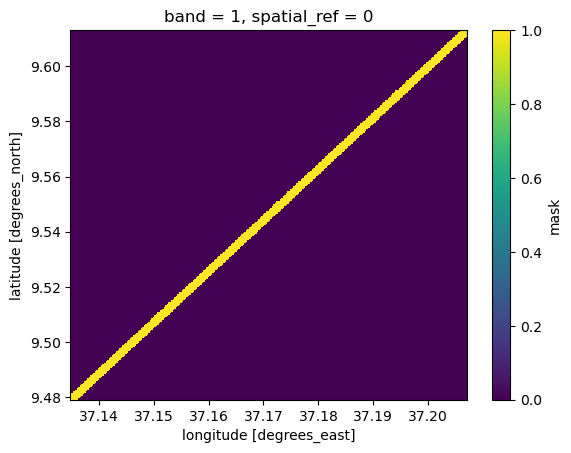

In [67]:
# mask = ds.elevation.rio.clip(gdf.buffer(.0005))
# gdf = gpd.read_file("roi.shp")
clipped = xr.ones_like(ds.elevation, dtype=np.ubyte).rio.clip(gdf.buffer(0.001))
ds["mask"] = clipped
ds.mask.fillna(0)
ds["mask"] = ds["mask"].fillna(0)
ds.mask.plot()

In [58]:
import cython

In [59]:
print(bool(np.nan))

True


In [60]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [61]:
%%cython -+
from libcpp.queue cimport queue
from libcpp.vector cimport vector
from libc.math cimport isnan

cdef struct xypoint:
    long x
    long y


#     3 2 1
#     4 X 0
#     5 6 7
cdef int[8] dx = [1, 1, 0, -1, -1, -1, 0, 1]
cdef int[8] dy = [0, 1, 1, 1, 0, -1, -1, -1]
    
def upslope_cells(double[:,:] mask, float[:,:] dem) -> void:
    cdef queue[xypoint] qu
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i,j] != 0:
                qu.push(xypoint(i,j))

    while not qu.empty():
        point = qu.front()
        qu.pop()
        
        for i in range(8):
            x = point.x + dx[i]
            y = point.y + dy[i]
            if x < 0 or x > mask.shape[0]:
                continue
            if y < 0 or y > mask.shape[1]:
                continue
            if mask[x,y] == 0:
                if dem[x,y] > dem[point.x,point.y]:
                    qu.push(xypoint(x,y))
                    mask[x,y] += 1

In [68]:
# gdf = geemap.ee_to_geopandas(ee.FeatureCollection(Map.draw_last_feature))
# gdf.to_file("roi.shp")
upslope_cells(ds.mask.squeeze().data, ds.filled.squeeze().data)

ValueError: Buffer dtype mismatch, expected 'double' but got 'unsigned char'

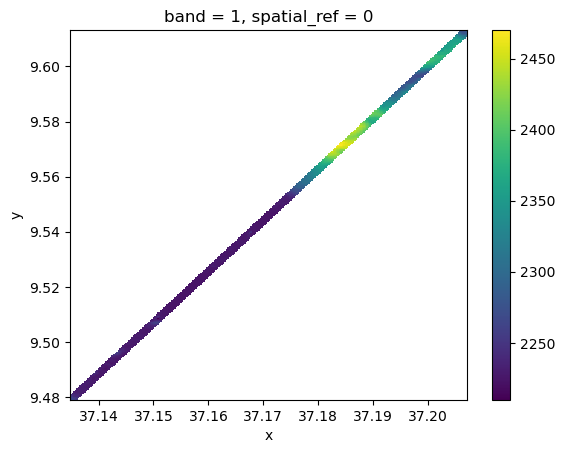

In [69]:
# ds.mask.plot()
# ds.dropna("x",how="all",subset=["mask"]).dropna("y",how="all",subset=["mask"]).mask.plot()
extracted = xr.where(ds.mask != 0, ds.elevation, np.nan).dropna("x",how="all").dropna("y",how="all").rio.write_crs(4326)
extracted.plot()
extracted = extracted.fillna(-9999).rio.write_nodata(-9999)

In [14]:
extracted.rio.to_raster("dem.tif")